In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sess = tf.Session()

train, test = tf.keras.datasets.mnist.load_data()
x_train = train[0]/255.
x_train = x_train[..., None]


In [2]:
latent = 49
img_size = (28, 28, 1)
classes = 10


def conv_layer(inp, filters, kernel_size=(3, 3), dropout=0, transpose=False, **kwargs):
    out = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same', **kwargs)(inp)
    if transpose:
        out = tf.keras.layers.Conv2DTranspose(filters, kernel_size=kernel_size, padding='valid', **kwargs)(inp)
    if dropout:
        out = tf.keras.layers.Dropout(rate=dropout)(out)
    out = tf.keras.layers.PReLU(shared_axes=[1, 2])(out)
    return out


# Define discriminator
def get_discriminator(img_dim=(28, 28, 1), class_dim=10, filters=32):
    x_input = tf.keras.layers.Input(img_dim)

    d = conv_layer(x_input, filters=filters)
    d = conv_layer(d, filters=filters)
    d = conv_layer(d, filters=filters, strides=(2, 2))
    d = conv_layer(d, filters=filters, strides=(2, 2))
    d = tf.keras.layers.Flatten()(d)
    d = tf.keras.layers.Dense(class_dim, activation='relu')(d)

    y_input = tf.keras.layers.Input(img_dim)
    dy = conv_layer(y_input, filters=filters)
    dy = conv_layer(dy, filters=filters)
    dy = conv_layer(dy, filters=filters, strides=(2, 2))
    dy = conv_layer(dy, filters=filters, strides=(2, 2))
    dy = tf.keras.layers.Flatten()(dy)
    dy = tf.keras.layers.Dense(class_dim, activation='relu')(dy)

    out = tf.keras.layers.Concatenate()([d, dy])
    out = tf.keras.layers.Dense(256, activation='relu')(out)
    out = tf.keras.layers.Dense(1, activation='relu')(out)
    
    r = conv_layer(x_input, filters=filters, strides=(4, 4))
    r = tf.keras.layers.Flatten()(r)
    r = tf.keras.layers.Dense(1, activation='relu')(r)
    
    out = tf.keras.layers.Add()([out, r])
    

    discriminator = tf.keras.Model(inputs=[x_input, y_input], outputs=out)
    return discriminator

disc = get_discriminator()
dvars = disc.trainable_variables

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
class gradient_descent(tf.keras.layers.Layer):
    def __init__(self, discriminator, iterations=10, eta=1e-3, sigma=0.1):
        super(gradient_descent, self).__init__()
        self.iterations = iterations
        self.eta = eta
        self.discriminator = discriminator
        self.sigma = sigma

    def build(self, input_shape):
        # Build gradients here for hopefully faster execution
        self.discriminator.trainable = False
        pass


    def call(self, input):
        out = input[0]
        y = input[1]
        #tik = self.discriminator([out, y])
        err = [self.discriminator([out, y])]
        for iteration in range(self.iterations):
            grads = tf.gradients(self.discriminator([out, y]), out)[0]
            out = out - self.eta*(grads + self.sigma*out)
            err.append(self.discriminator([out, y]))
        return out


In [4]:
def get_generator(discriminator, K=10, img_dim=(28, 28, 1), filters=32):
    y_input = tf.keras.layers.Input(img_dim)
    d = conv_layer(y_input, filters=filters)
    d = conv_layer(d, filters=filters)
    d = conv_layer(d, filters=filters)
    d = conv_layer(d, filters=filters)
    x0 = conv_layer(d, filters=1)
    
    # Gradient descent
    eta = 1e-1
    out = gradient_descent(discriminator, eta=eta)([x0, y_input])
        
    generator = tf.keras.Model(inputs=y_input, outputs=[out, x0])
    return generator

In [5]:
gen = get_generator(disc)
gvars = gen.trainable_variables

In [6]:
# Discriminator tries to map x_true to output 1 and generator_out to output 0
# Generator tries to find images such that discriminator thinks they are output 1
LAM = 1e2
lr = 1e-3

x = tf.placeholder(tf.float32, (None, ) + img_size)
y = tf.placeholder(tf.float32, (None, ) + img_size)

line = tf.placeholder(tf.float32, (None, 1, 1, 1))

x_gen = gen(y)[0]
x_init = gen(y)[1]
x_line = x*line + x_gen*(1-line)


lip = LAM*sum([(tf.reduce_mean(g**2)-1)**2 for g in tf.gradients(disc([x_line, y]), [x_line, y])])

loss_disc = tf.reduce_mean(-disc([x_gen, y]) + disc([x, y]) + lip)
loss_gen = tf.reduce_mean(disc([x_gen, y]))


opt = tf.train.AdamOptimizer(learning_rate=lr)

grads_gen, _ = tf.clip_by_global_norm(tf.gradients(loss_gen, gvars), 1.)
grads_disc, _ = tf.clip_by_global_norm(tf.gradients(loss_disc, dvars), 1.)

train_gen = opt.apply_gradients(zip(grads_gen, gvars))
train_disc = opt.apply_gradients(zip(grads_disc, dvars))

############
# Active gradients

total_gen = int(np.sum([np.prod(t.shape) for t in gvars]))
active_gen = sum([tf.count_nonzero(grad) for grad in grads_gen if grad is not None])/total_gen

total_disc = int(np.sum([np.prod(t.shape) for t in dvars]))
active_disc = sum([tf.count_nonzero(grad) for grad in grads_disc if grad is not None])/total_disc

sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.cast instead.


In [7]:
def generate_batch(batch_size=8):
    x = x_train[np.random.choice(60000, batch_size), ...]
    y = x + np.random.normal(0, 0.2, x.shape)
    return x, y

### Epoch 0 ###
[ 0.  0.] 0.976000, Disc: 185.904984, Gen: 43.2299126


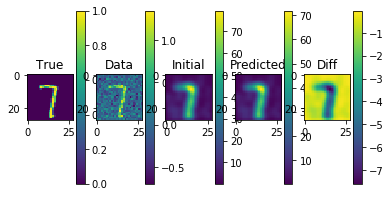

###############
### Epoch 1 ###
[ 0.  0.] 0.976000, Disc: 200.000000, Gen: 0.000000


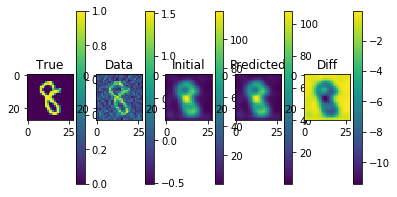

###############
### Epoch 2 ###


KeyboardInterrupt: 

In [8]:
epochs = 20
N = 2000
batch_size = 32
ncritic = 5

for epoch in range(epochs):
    LOSSD = []
    LOSSG = []
    print("### Epoch %d ###" % epoch)

    for batch in range(N // batch_size):
        CRITIC = []
        for i in range(ncritic):
            xinp, yinp = generate_batch(batch_size=batch_size)
            t = np.random.uniform(0, 1, (batch_size, 1, 1, 1))
            fd = {x: xinp,
                 y: yinp,
                 line: t}
            ld, _ = sess.run([loss_disc, train_disc], feed_dict=fd)
            CRITIC.append(ld)
            
        _, yinp = generate_batch(batch_size=batch_size)
        lg, _ = sess.run([loss_gen, train_gen], feed_dict={y: yinp})

        LOSSG.append(lg)
        LOSSD.append(np.mean(CRITIC))
        print("Progress: %f, Disc: %f, Gen: %f" % (batch*batch_size/N, np.mean(LOSSD), np.mean(LOSSG)), end='\r')
    
    xinp, yinp = generate_batch(batch_size=1)
    gx = sess.run([x_init, x_gen], feed_dict={y: yinp})
    dx = sess.run(disc([x, y]), feed_dict={y: np.concatenate([yinp, yinp]), x: np.concatenate(gx)})
    print(dx.flatten())
    plt.subplot(151)
    plt.imshow(xinp[0, ..., 0])
    plt.title("True")
    plt.colorbar()
    
    plt.subplot(152)
    plt.imshow(yinp[0, ..., 0])
    plt.title("Data")
    plt.colorbar()

    plt.subplot(153)
    plt.imshow(gx[0][0, ..., 0])
    plt.title("Initial")
    plt.colorbar()
    
    plt.subplot(154)
    plt.imshow(gx[1][0, ..., 0])
    plt.title("Predicted")
    plt.colorbar()
    
    plt.subplot(155)
    plt.imshow(gx[1][0, ..., 0] - gx[0][0, ..., 0])
    plt.title("Diff")
    plt.colorbar()

    plt.show()

    print("###############")